# PRESC - Misclassification Rate

#### Requirements:
* Misclassification rate = misclassified points / total number of predictions.
* Develop a function that takes the model and the data and computes the misclassifications.
* Take a specific feature and then compute the rate of misclassifications.
* Misclassification rate changes for different values of that feature (quantile/decile binning).
* The quantiles must be those of the feature values in the test dataset.
* The function should provide the list of numbers. Visualization should be in a later step.

#### Functions:
* misclass_rate_feature(test_dataset, test_dataset_misclassifications, feature, bins=10)
* show_misclass_rate_feature(test_dataset, test_dataset_misclassifications, feature, bins=10)
* show_misclass_rates_features(test_dataset, test_dataset_misclassifications, bins=10)    
     
     
* compute_tiles(dataset, feature, tiles=4)    
* show_tiles_feature(dataset, feature, tiles=4)
* show_tiles_features(test_dataset, tiles=4)

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from presc.misclassifications.misclass_rate import (misclass_rate_feature, show_misclass_rate_feature, 
show_misclass_rates_features, compute_quantiles, show_quantiles_feature, show_quantiles_features)

In [2]:
dataset_names = ("generated", "vehicles", "eeg", "winequality", "defaults")
dataset_files = ["../datasets/" + dataset_names[x] + ".csv" for x in range(len(dataset_names))]

## Train a classification model (winequality.csv)
A detailed description of this training section is already included in the jupyter notebook **alberginia_issue2_5datasets.ipynb**.

In [3]:
dataset = pd.read_csv(dataset_files[3])
dataset = dataset.drop(columns=["quality"])

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5806, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = SVC(kernel="linear", decision_function_shape="ovr", class_weight="balanced")
classifier.fit(X_train_scaled, y_train)
y_test_predict = classifier.predict(X_test_scaled)

Rebuild the test dataset with the true class: 

In [4]:
dataset_test = X_test.merge(y_test, left_index=True, right_index=True, how='left')

Build dataset with only the test misclassifications subset:

In [5]:
dataset_test_misclass = dataset_test[ dataset_test.iloc[:,-1] != y_test_predict ]

## How to compute the total misclassification rate for one feature?

### List of features

In [6]:
feature_list = list(dataset.columns)
print(feature_list)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'recommend']


### Compute the feature histogram of all and only the misclassified points with the same binning

In [7]:
# Histogram with regular intervals (first item are the counts, second item the box intervals)
total_histogram_counts, bins = np.histogram(dataset_test["alcohol"])
print(total_histogram_counts, bins)

[ 13 359 594 436 449 390 216 250 101  36] [ 8.   8.6  9.2  9.8 10.4 11.  11.6 12.2 12.8 13.4 14. ]


In [8]:
# Histogram with regular intervals (first item are the counts, second item the box intervals)
misclass_histogram_counts, bins = np.histogram(dataset_test_misclass["alcohol"], bins)
print(misclass_histogram_counts, bins)

[  1  49  26  56 167 221 118 137  37  11] [ 8.   8.6  9.2  9.8 10.4 11.  11.6 12.2 12.8 13.4 14. ]


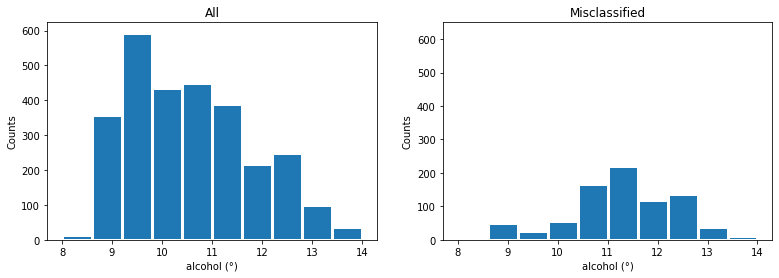

In [9]:
fig, axs = plt.subplots(1,2,figsize=(13,4))
axs[0].set_title('All')
axs[1].set_title('Misclassified')
axs[0].set_xlabel("alcohol (°)")
axs[0].set_ylabel("Counts")
axs[1].set_xlabel("alcohol (°)")
axs[1].set_ylabel("Counts")
plt.gca().set_ylim([0, 650])
figure1 = axs[0].bar(bins[:-1], total_histogram_counts, width= 0.6, bottom=None, align='edge', edgecolor="white", 
                     linewidth=3)
figure2 = axs[1].bar(bins[:-1], misclass_histogram_counts, width=0.6, bottom=None, align='edge', edgecolor="white",
                     linewidth=3)

### Divide bin by bin

Misclassification rate = Feature histogram of misclassified points / Feature histogram of all points

## Misclassification rate of a feature by regular intervals

In [10]:
misclass_rate_histogram = misclass_rate_feature(dataset_test, y_test_predict, "alcohol")
print(misclass_rate_histogram)

(array([ 8. ,  8.6,  9.2,  9.8, 10.4, 11. , 11.6, 12.2, 12.8, 13.4, 14. ]), [0.07692307692307693, 0.13649025069637882, 0.04377104377104377, 0.12844036697247707, 0.37193763919821826, 0.5666666666666667, 0.5462962962962963, 0.548, 0.36633663366336633, 0.3055555555555556], [0.09825769985481651, 0.026702287154455075, 0.010380155615174526, 0.02331474397286034, 0.04633422106676243, 0.06681240706049493, 0.08746140526384037, 0.08147736279832393, 0.09667722905024931, 0.14305439232468703])


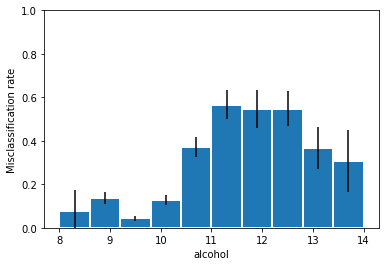

In [11]:
show_misclass_rate_feature(dataset_test, y_test_predict, "alcohol")

## Misclassification rate of a feature by quartiles

In [12]:
misclass_rate_histogram = misclass_rate_feature(dataset_test, y_test_predict, "alcohol", bins="quartiles")
print(misclass_rate_histogram)

(array([ 8. ,  9.5, 10.4, 11.4, 14. ]), [0.08356940509915015, 0.10488505747126436, 0.4327731092436975, 0.5247252747252747], [0.014024985892179608, 0.016251525293650183, 0.0408157285638348, 0.0462948931784603])


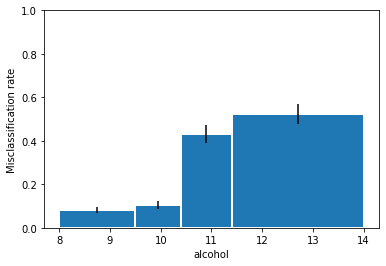

In [13]:
show_misclass_rate_feature(dataset_test, y_test_predict, "alcohol", bins="quartiles")

## How good are these quartiles? Is the sample really equally distributed between them?

[ 8.   9.5 10.4 11.4 14. ]


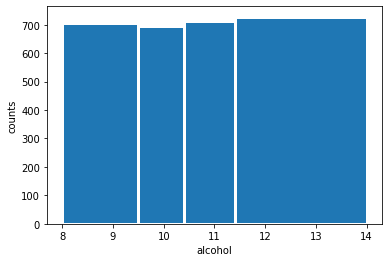

In [14]:
quartiles_alcohol = compute_quantiles(dataset_test, "alcohol")
print(quartiles_alcohol)
show_quantiles_feature(dataset_test, "alcohol", quantiles=4)

Although the "compute_quantiles" function tries to determine the optimal feature value ranges in order
to obtain **groups of data of similar sizes** (i.e. with an equal amount of samples), **often this is not strictly possible**. In particular, when the precision of the feature is small and many data points share the same feature values (i.e. the feature behaves as pseudo-discrete). 

When this happens, such subsets of data points sharing the same value either get all counted in one bin or they get all counted in another. Which makes it impossible to perfectly equilibrate the different groups.
    
To arbitrarily split between two contiguous bins a subset of data points with the same feature value wouldn't be acceptable because this would distort the operations betwen different histograms that need to be carried out.

## Misclassification rate of a feature by deciles

In [15]:
misclass_rate_histogram = misclass_rate_feature(dataset_test, y_test_predict, "alcohol", bins="deciles")
print(misclass_rate_histogram)

(array([ 8. ,  9. ,  9.4,  9.6, 10. , 10.4, 10.7, 11.2, 11.7, 12.4, 14. ]), [0.12626262626262627, 0.08791208791208792, 0.043478260869565216, 0.07526881720430108, 0.14736842105263157, 0.3228346456692913, 0.4652567975830816, 0.599290780141844, 0.5503597122302158, 0.4478114478114478], [0.03422561937523613, 0.020148653813866622, 0.015168176571204237, 0.020931228706606683, 0.031468792929810696, 0.05590756984358393, 0.06306428754955369, 0.08178653740271097, 0.07750232762081011, 0.0648148328014817])


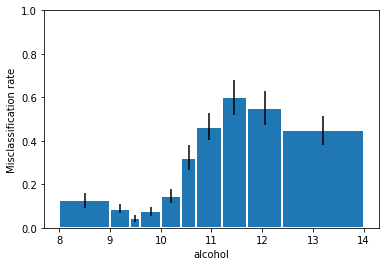

In [16]:
show_misclass_rate_feature(dataset_test, y_test_predict, "alcohol", bins="deciles")

## How good are these deciles? Is the sample really equally distributed between them?

[ 8.   9.   9.4  9.6 10.  10.4 10.7 11.2 11.7 12.4 14. ]


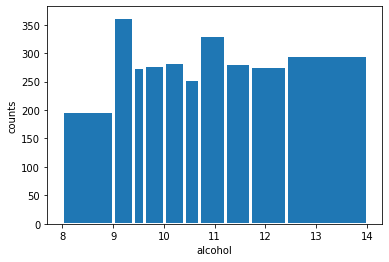

In [17]:
deciles_alcohol = compute_quantiles(dataset_test, "alcohol", quantiles=10)
print(deciles_alcohol)
show_quantiles_feature(dataset_test, "alcohol", quantiles=10)

Not really. Here, for this dataset and for this feature, the non-homogoneity of the bins becomes noteworthy when trying to use deciles.

## Misclassification rate of a feature by arbitrary bins

In [18]:
misclass_rate_histogram = misclass_rate_feature(dataset_test, y_test_predict, "alcohol", [7, 9, 10, 11, 11.30, 15])
print(misclass_rate_histogram)

(array([ 7. ,  9. , 10. , 11. , 11.3, 15. ]), [0.12626262626262627, 0.07072905331882481, 0.2847411444141689, 0.535, 0.5258511979823455], [0.03422561937523613, 0.011105995542708582, 0.030205944225876136, 0.0895506149574233, 0.04442456751806431])


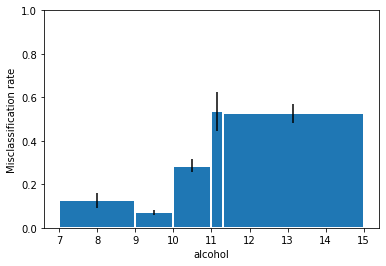

In [19]:
show_misclass_rate_feature(dataset_test, y_test_predict, "alcohol", [7, 9, 10, 11, 11.30, 15])

## Misclassification rate for all features by regular intervals
Here it can be seen that for most features, **the distribution of misclassifications is not uniform** and take place for certain values of each feature.

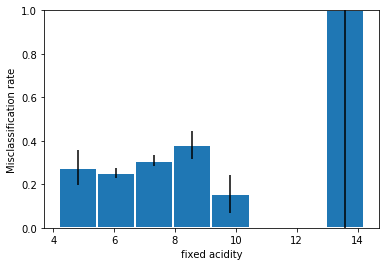

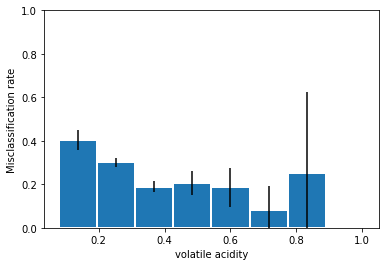

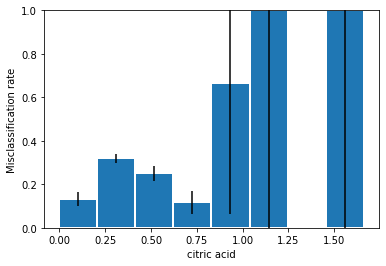

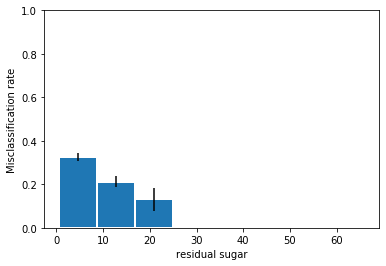

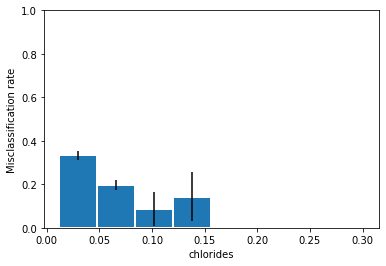

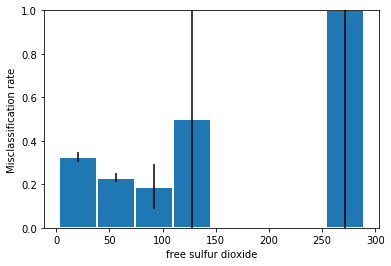

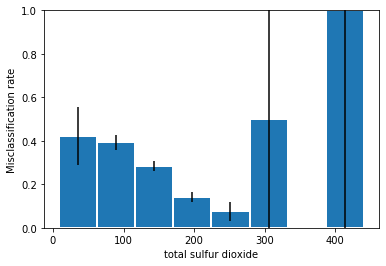

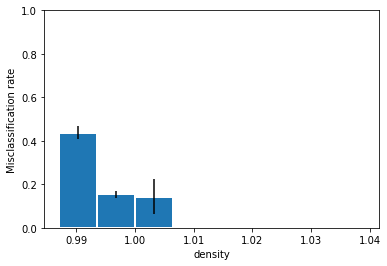

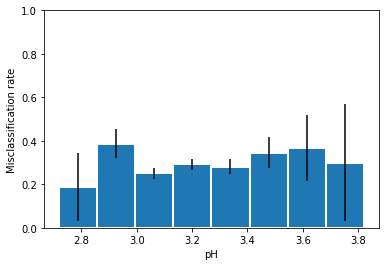

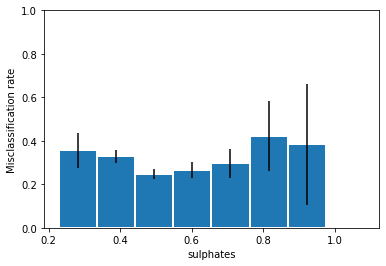

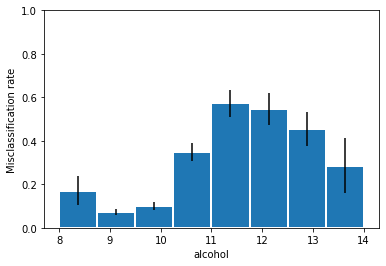

In [20]:
show_misclass_rates_features(dataset_test, y_test_predict, bins=8)

## Misclassification rate for all features by quartiles

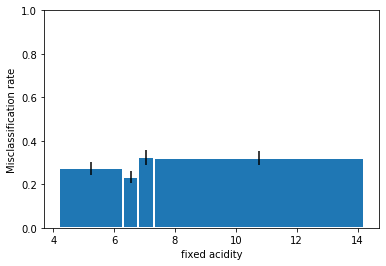

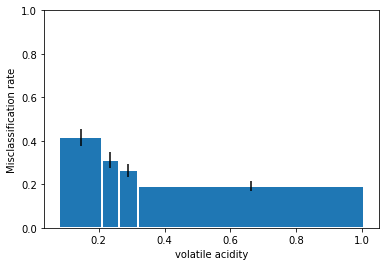

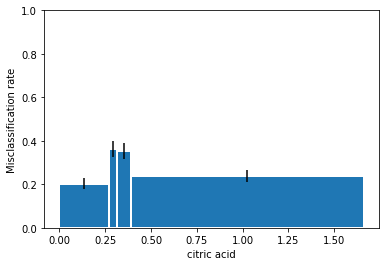

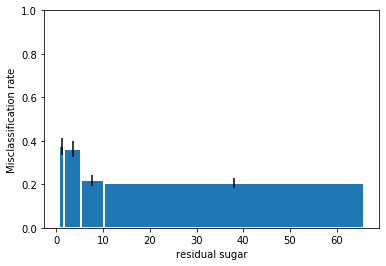

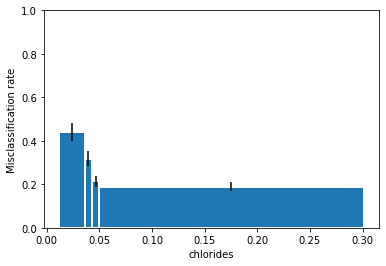

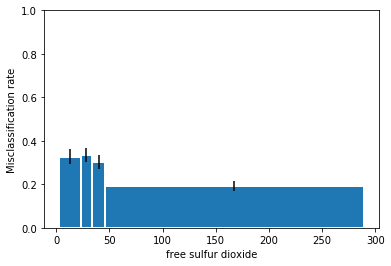

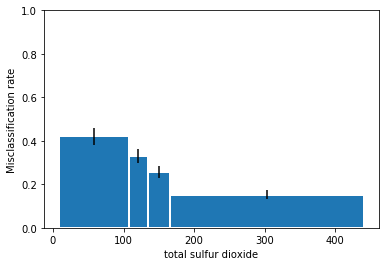

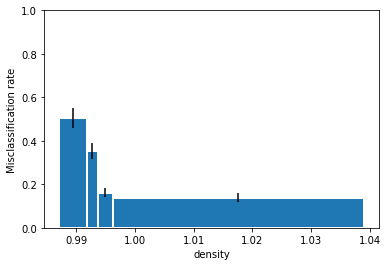

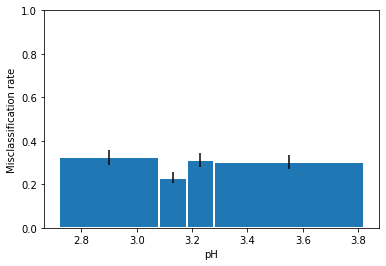

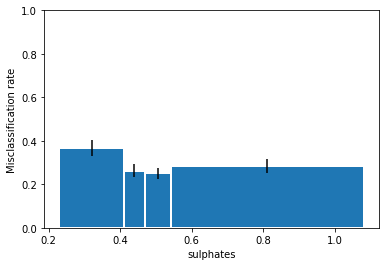

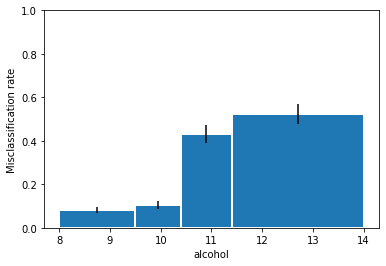

In [21]:
show_misclass_rates_features(dataset_test, y_test_predict, bins="quartiles")

## How good are these quartiles for all the features?

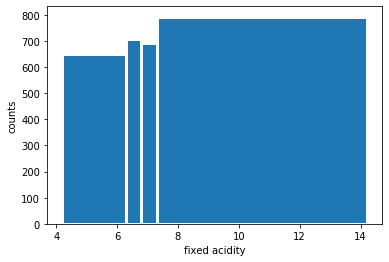

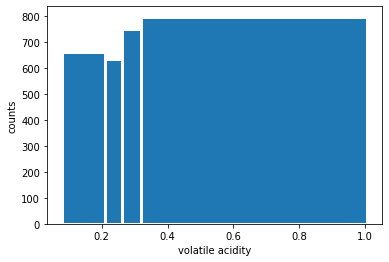

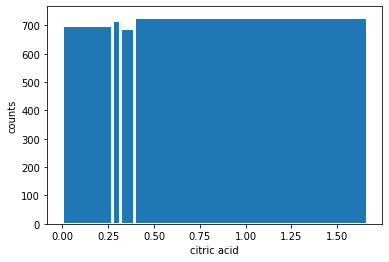

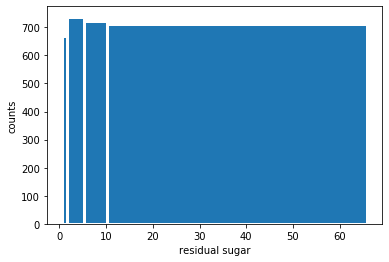

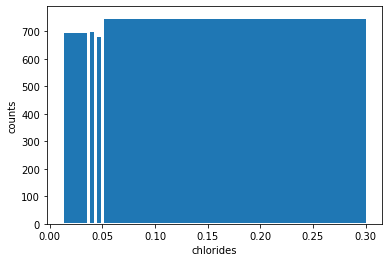

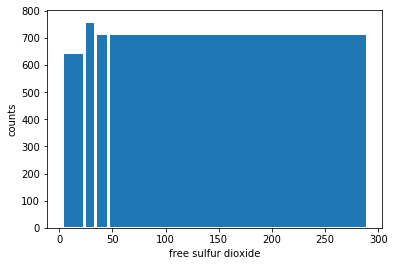

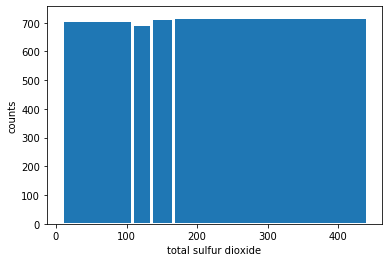

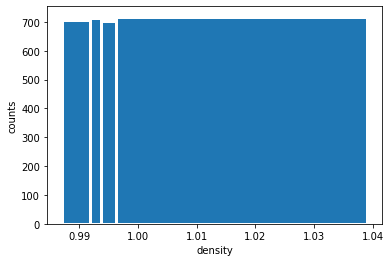

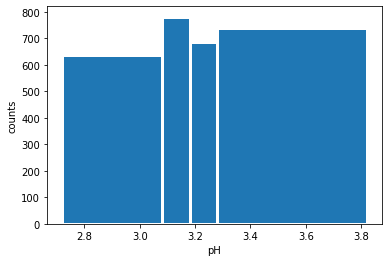

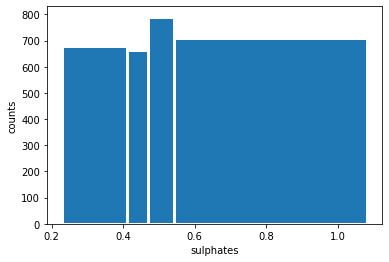

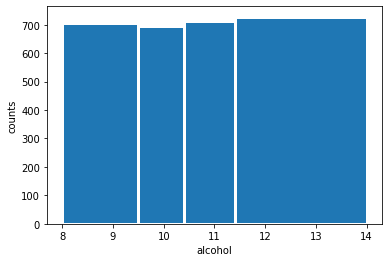

In [22]:
show_quantiles_features(dataset_test, quantiles=4)

--------------

# Vehicles dataset

In [23]:
dataset = pd.read_csv(dataset_files[1])

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = SVC(kernel='linear', decision_function_shape='ovo')
classifier.fit(X_train_scaled, y_train)
y_test_predict = classifier.predict(X_test_scaled)

In [24]:
dataset_test = X_test.merge(y_test, left_index=True, right_index=True, how='left')

### Misclassification rate by regular intervals

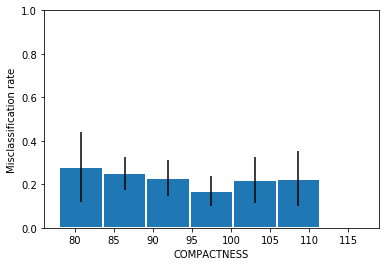

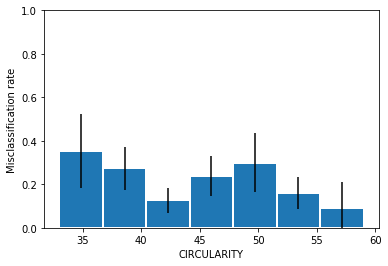

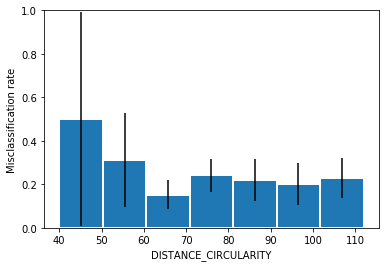

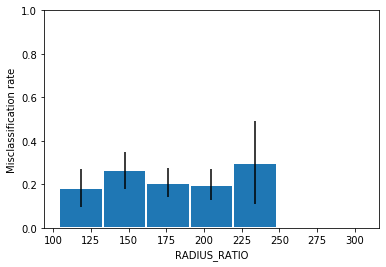

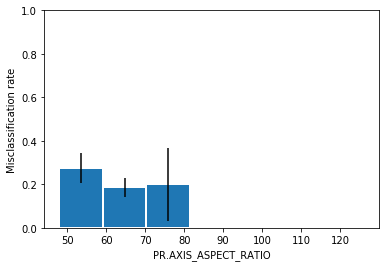

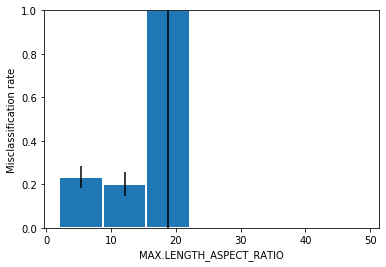

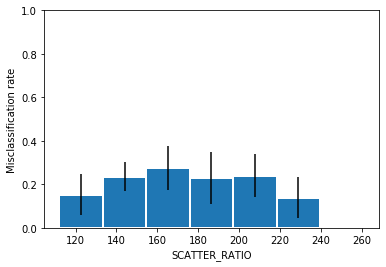

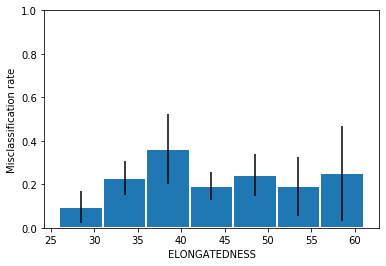

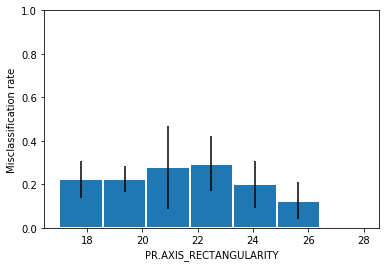

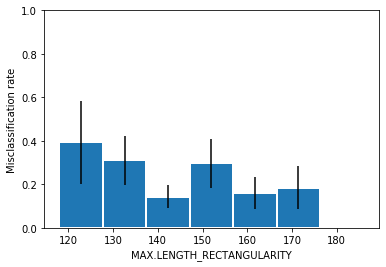

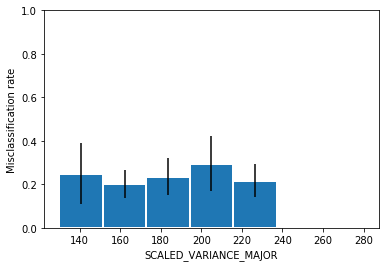

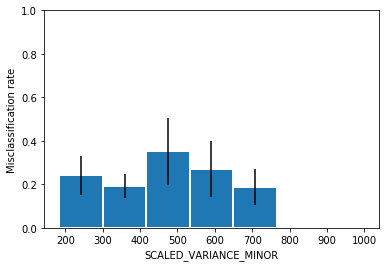

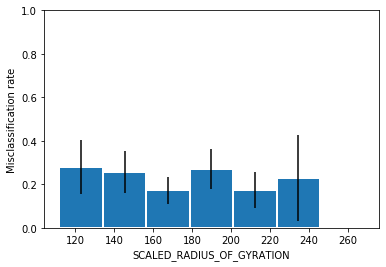

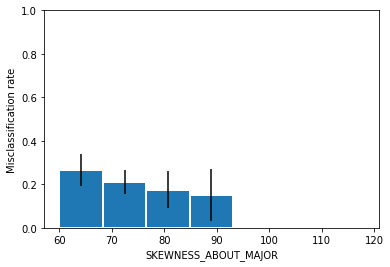

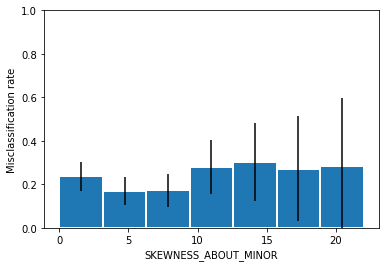

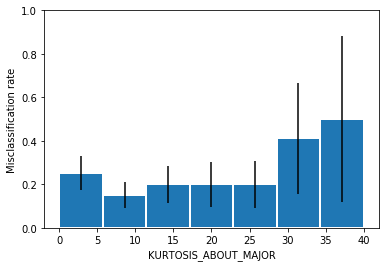

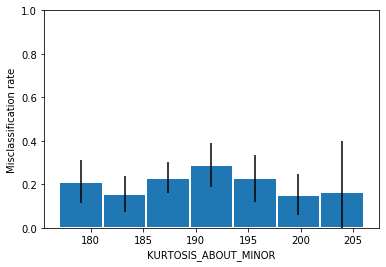

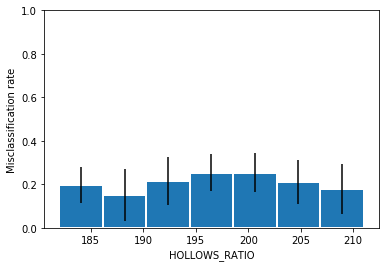

In [25]:
show_misclass_rates_features(dataset_test, y_test_predict, bins=7)

### Misclassification rate by quartiles

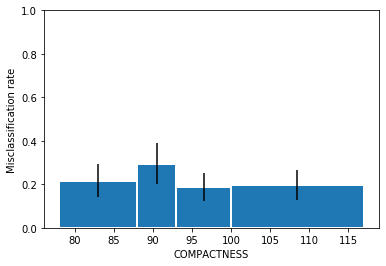

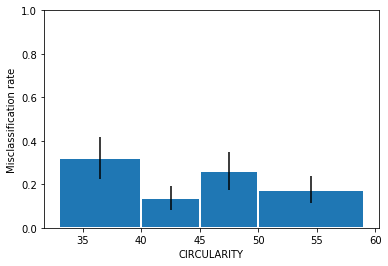

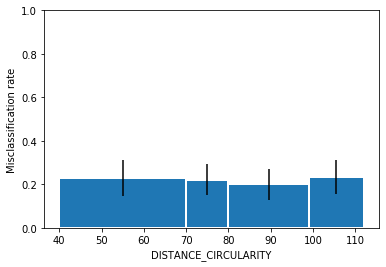

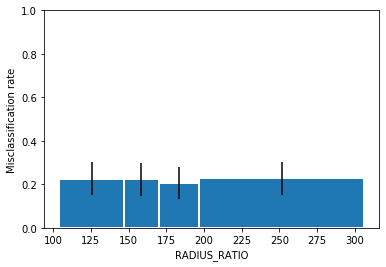

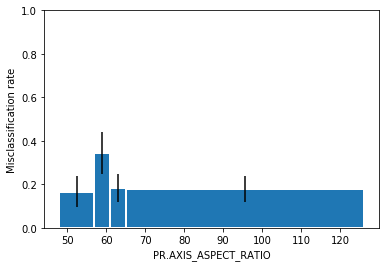

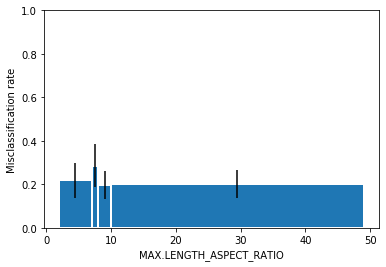

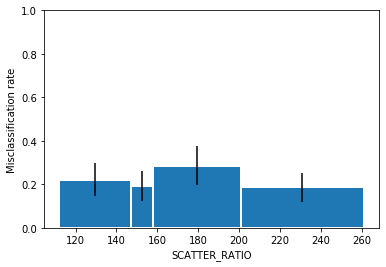

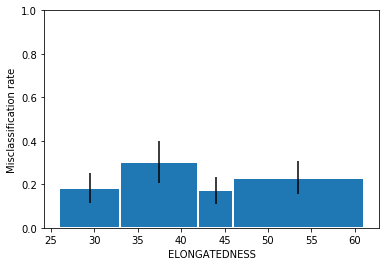

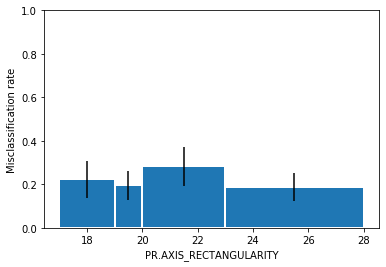

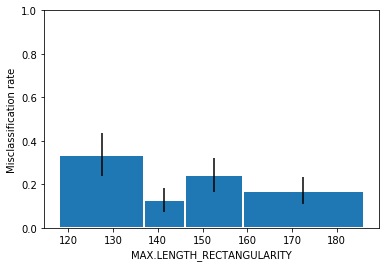

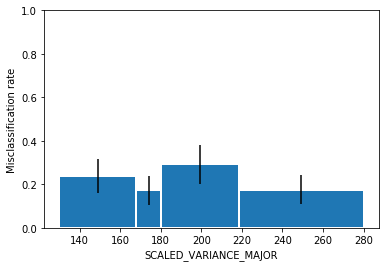

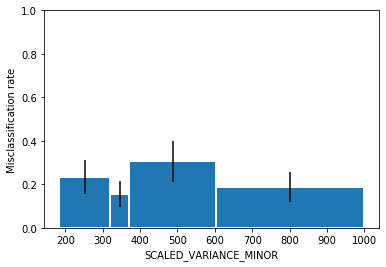

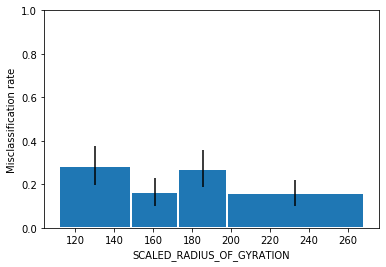

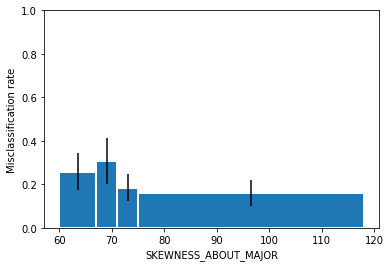

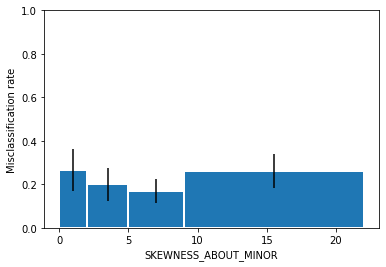

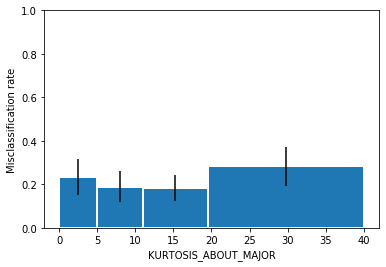

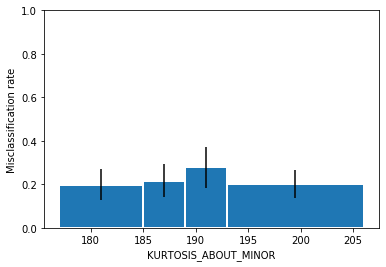

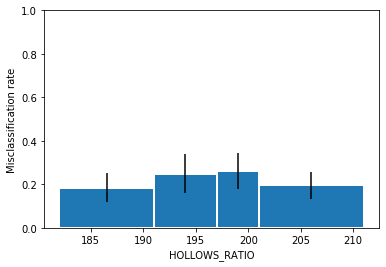

In [26]:
show_misclass_rates_features(dataset_test, y_test_predict, bins="quartiles")

### Goodness of the quartiles

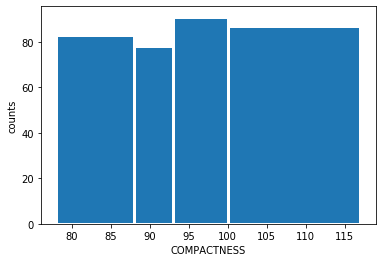

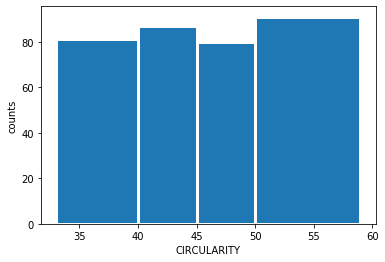

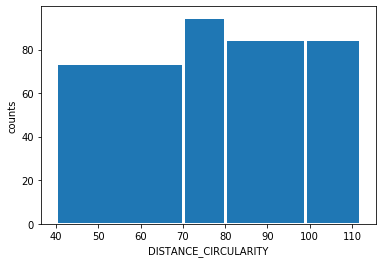

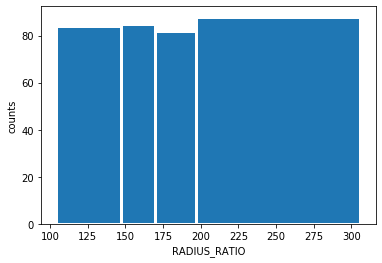

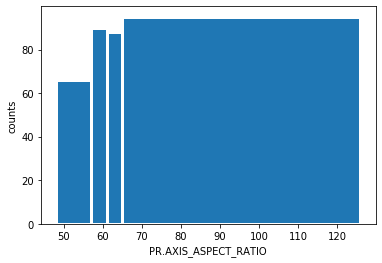

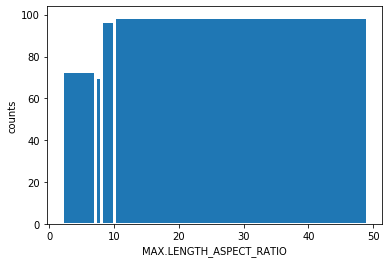

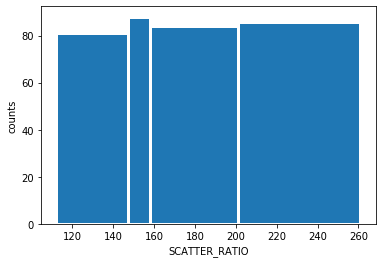

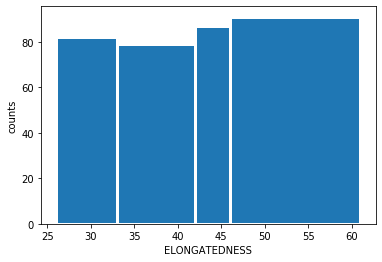

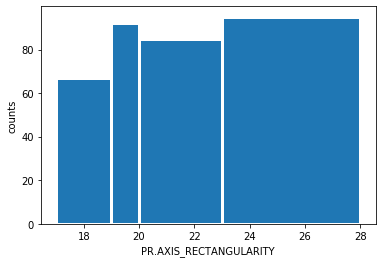

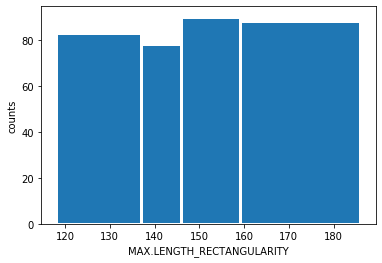

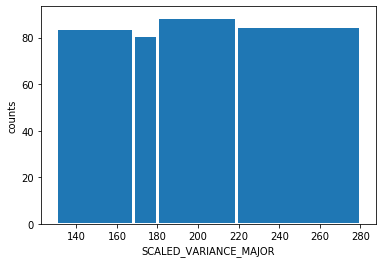

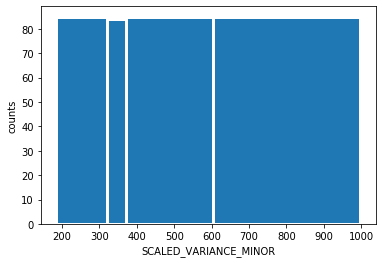

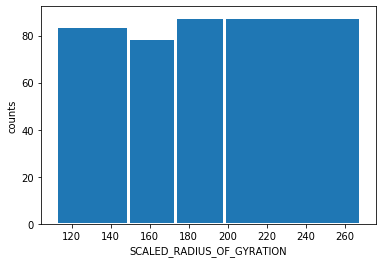

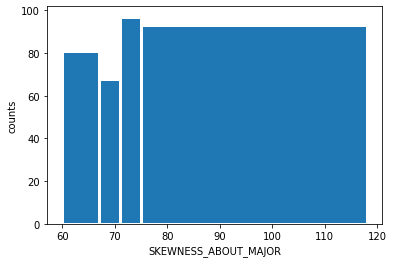

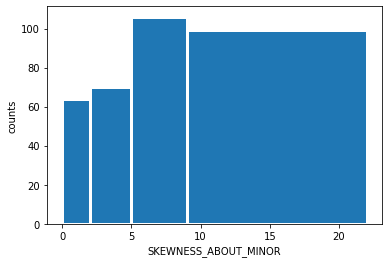

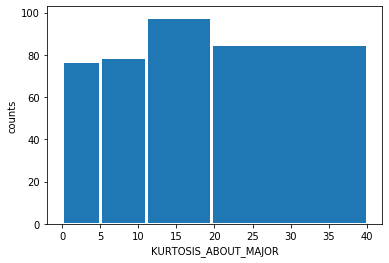

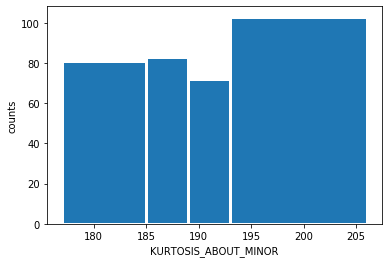

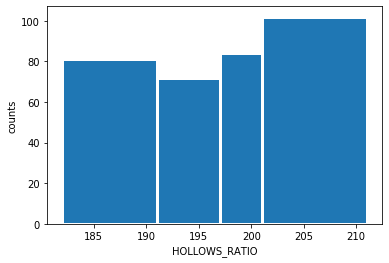

In [27]:
show_quantiles_features(dataset_test, quantiles=4)

--------------

# Defaults dataset

In [28]:
dataset = pd.read_csv(dataset_files[4])
# Readjust "pay" values to range from -1 to 9
dataset.iloc[:,6:12] = dataset.iloc[:,6:12].add(1)

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3636, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = SVC(kernel="linear", decision_function_shape="ovr", class_weight="balanced")
classifier.fit(X_train_scaled, y_train)
y_test_predict = classifier.predict(X_test_scaled)

In [29]:
dataset_test = X_test.merge(y_test, left_index=True, right_index=True, how='left')

### Misclassification rate by regular intervals

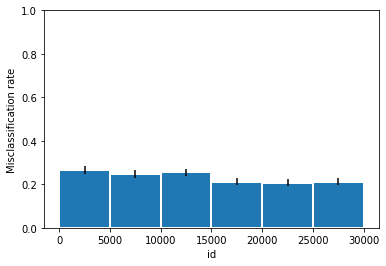

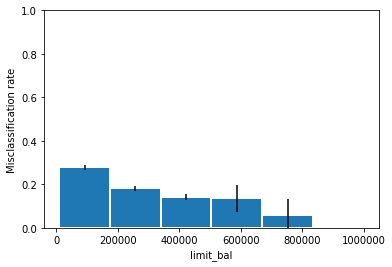

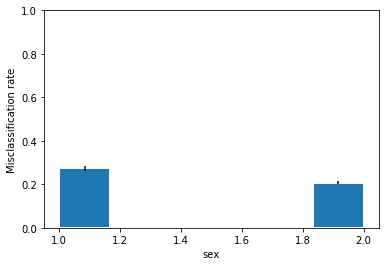

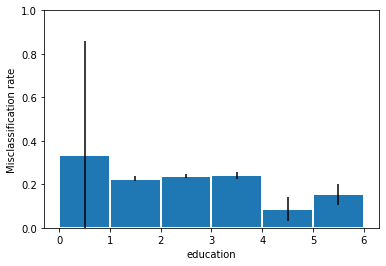

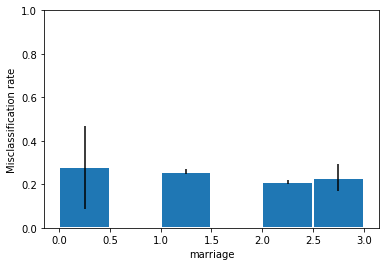

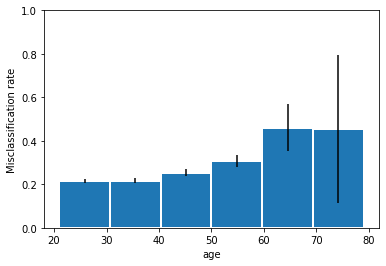

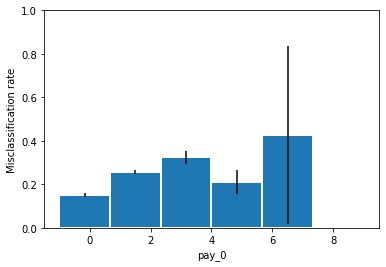

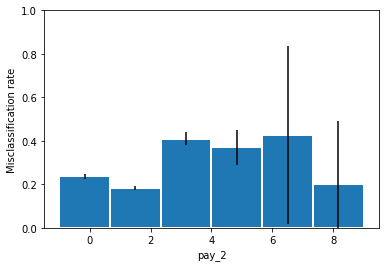

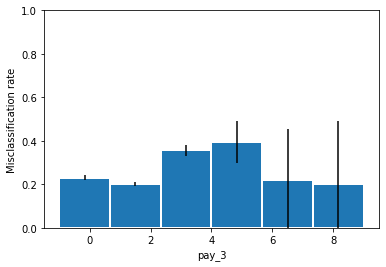

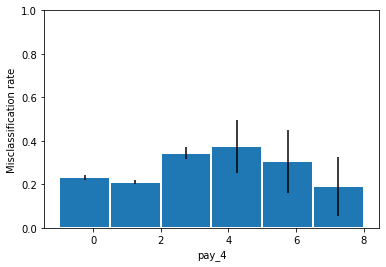

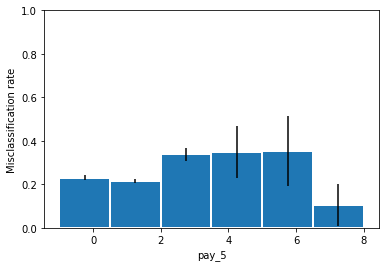

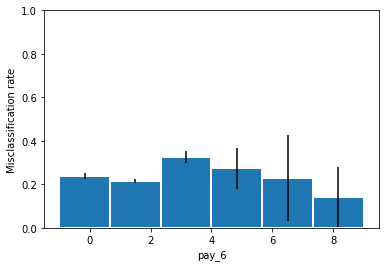

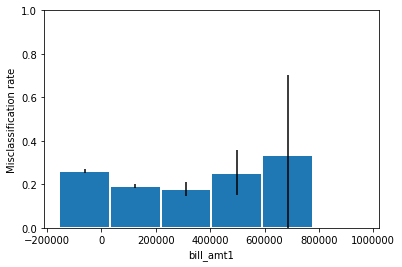

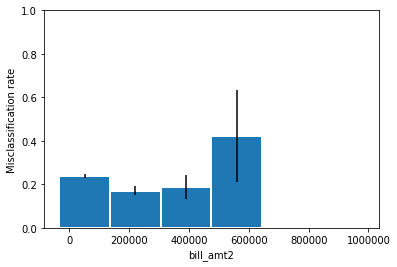

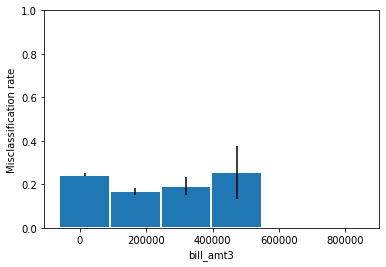

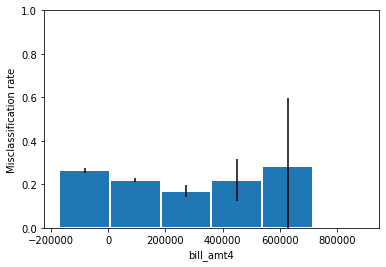

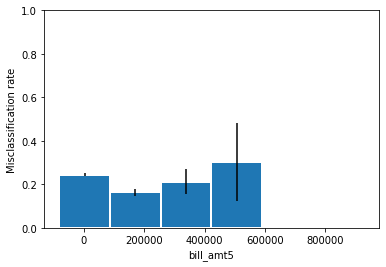

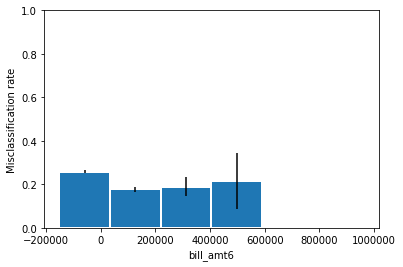

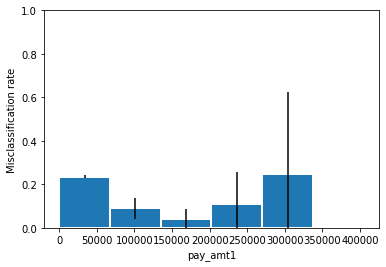

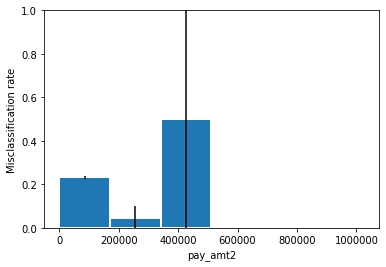

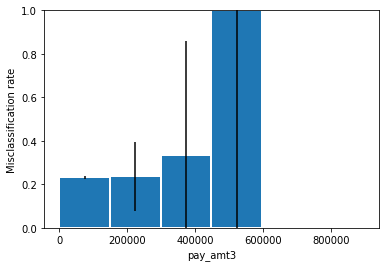

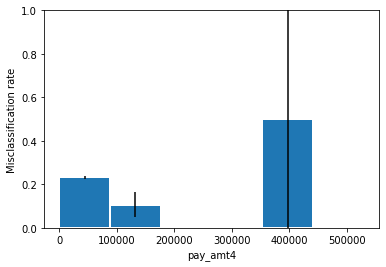

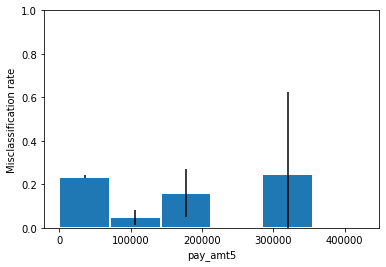

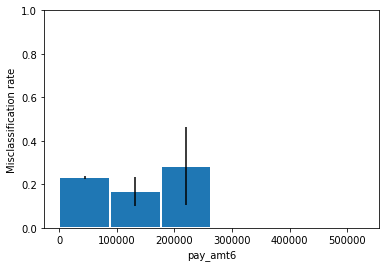

In [30]:
show_misclass_rates_features(dataset_test, y_test_predict, bins=6)

### Misclassification rate by quartiles

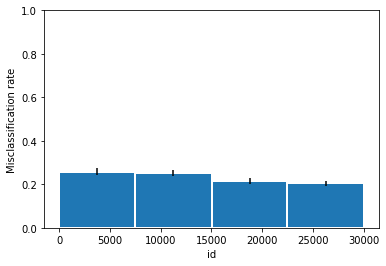

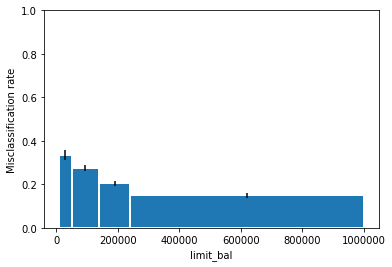

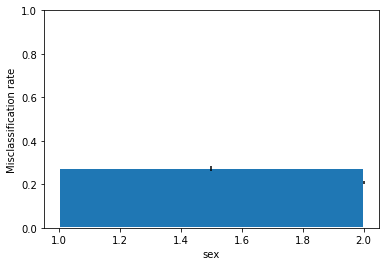

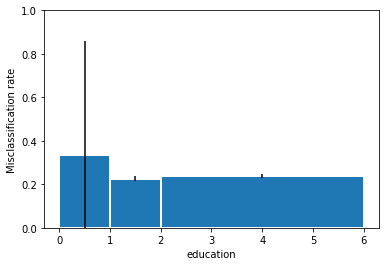

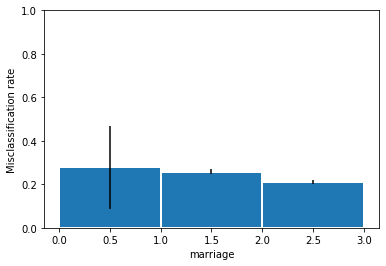

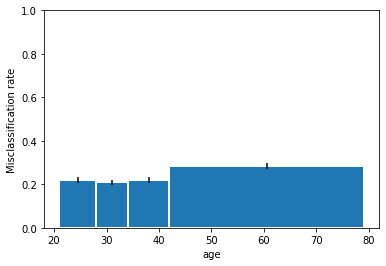

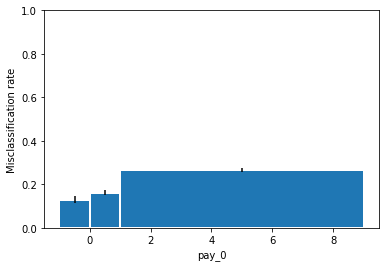

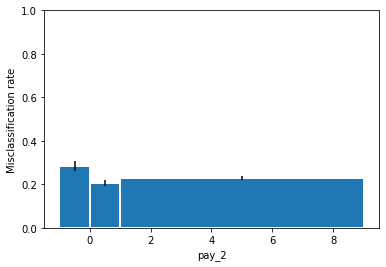

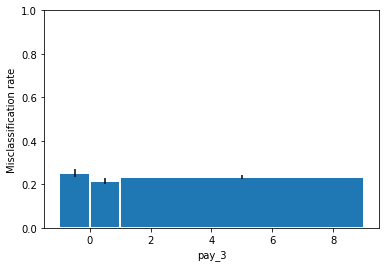

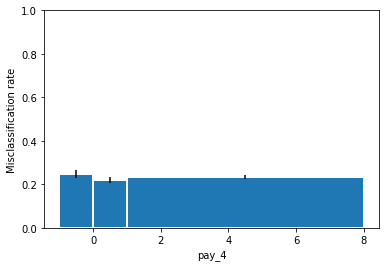

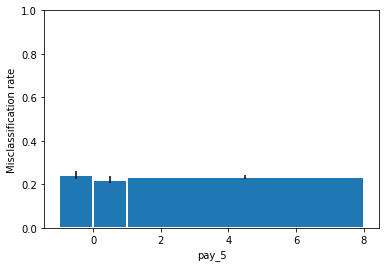

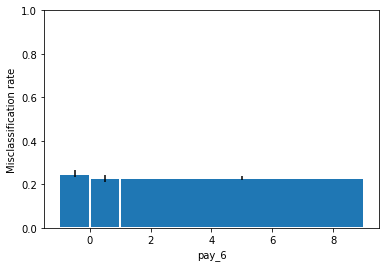

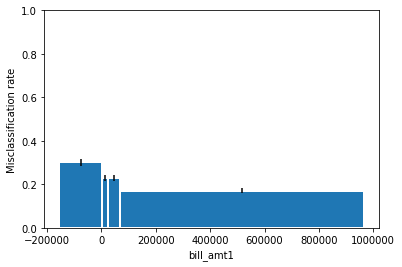

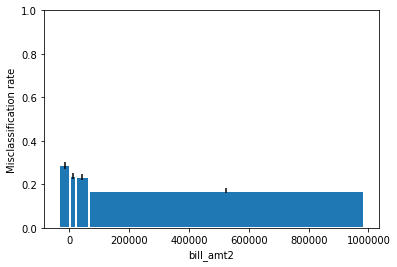

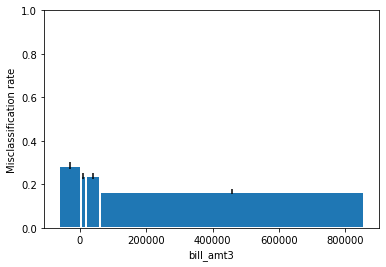

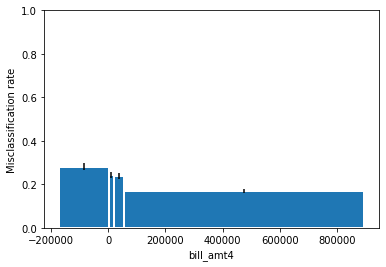

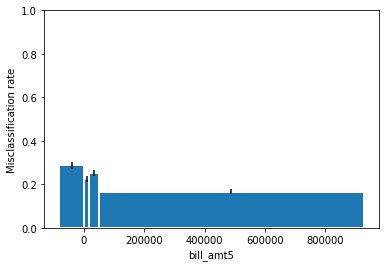

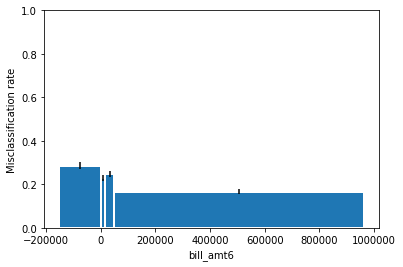

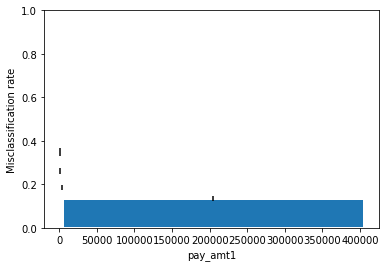

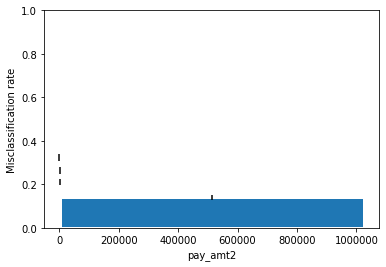

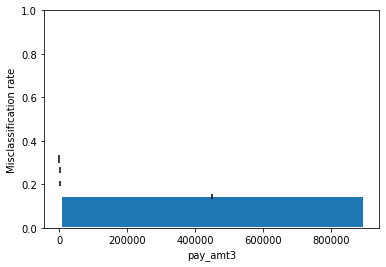

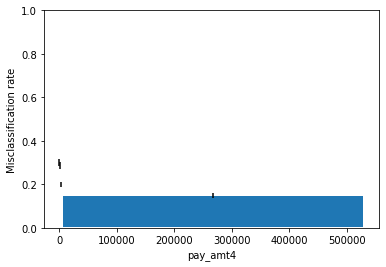

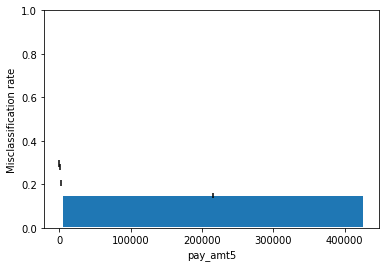

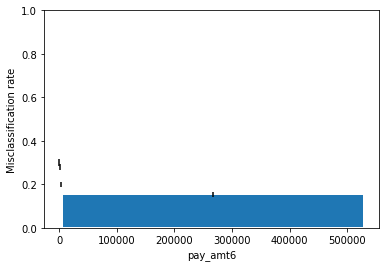

In [31]:
show_misclass_rates_features(dataset_test, y_test_predict, bins="quartiles")

### Goodness of the quartiles

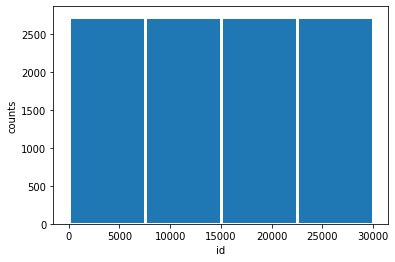

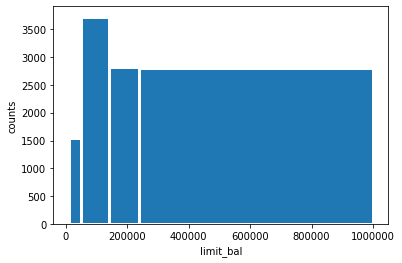

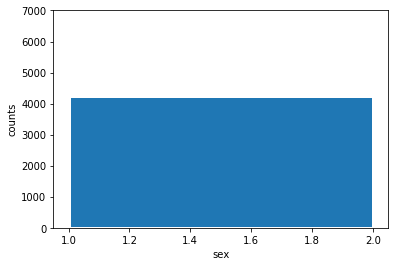

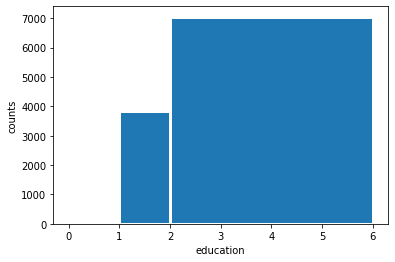

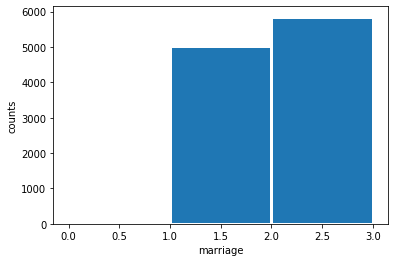

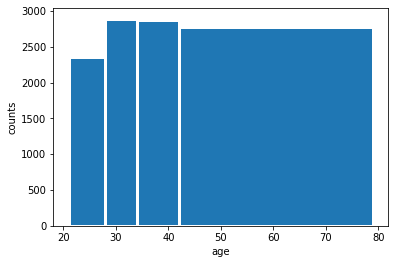

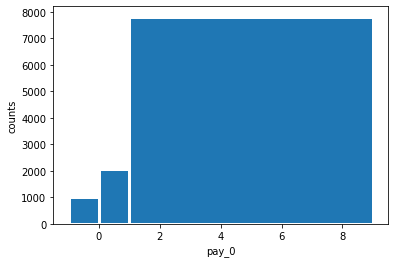

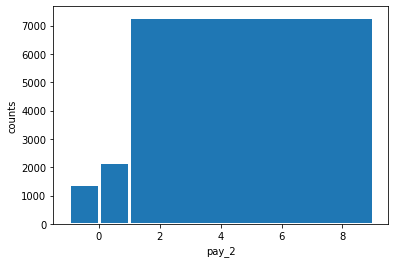

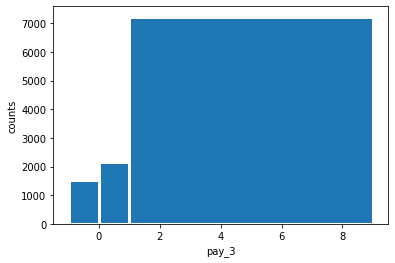

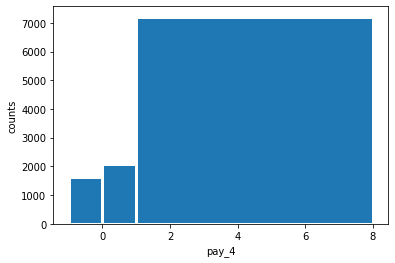

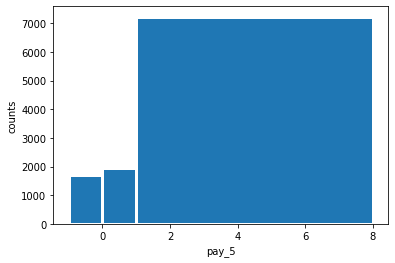

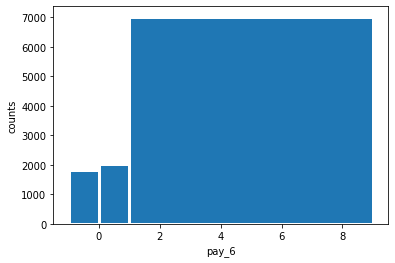

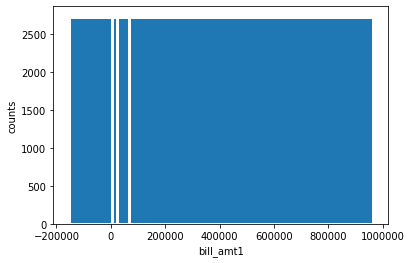

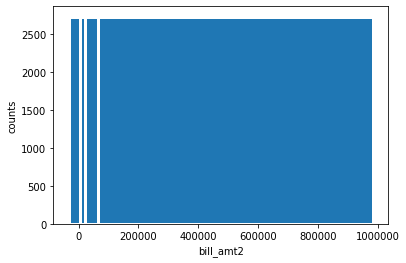

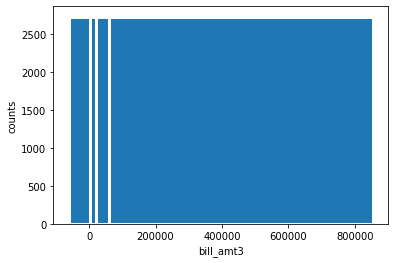

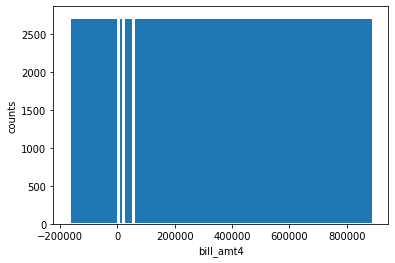

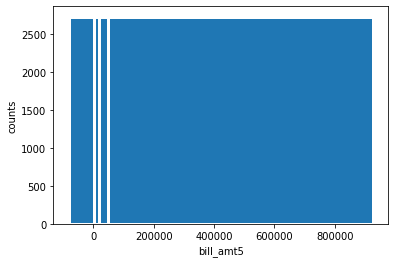

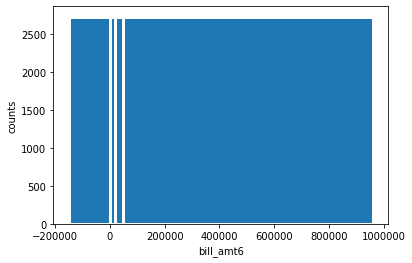

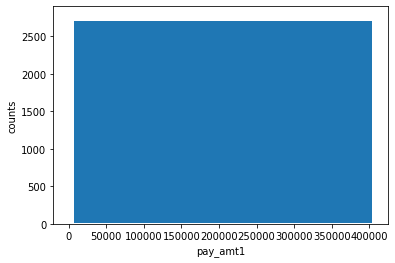

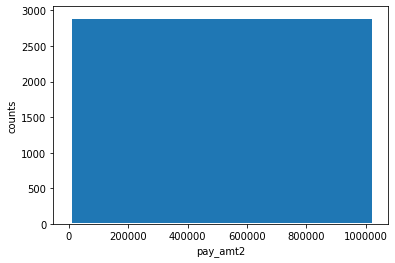

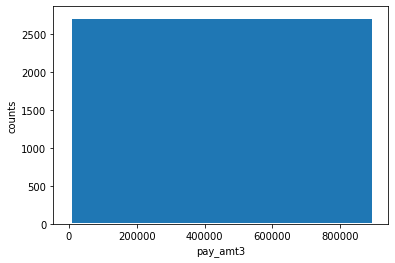

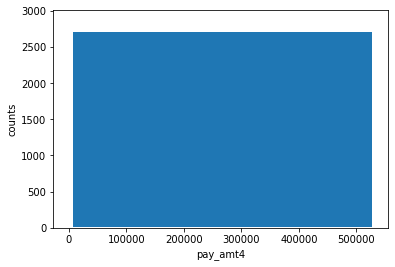

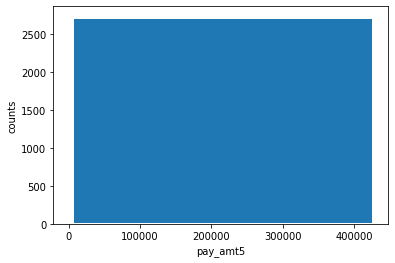

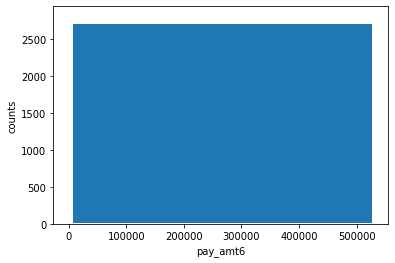

In [32]:
show_quantiles_features(dataset_test, quantiles=4)

--------------

# Eeg dataset

In [33]:
dataset = pd.read_csv(dataset_files[2])

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = SVC(kernel="linear", decision_function_shape="ovr")
classifier.fit(X_train_scaled, y_train)
y_test_predict = classifier.predict(X_test_scaled)

In [34]:
dataset_test = X_test.merge(y_test, left_index=True, right_index=True, how='left')

### Misclassification rate by regular intervals

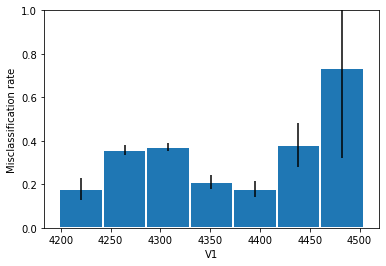

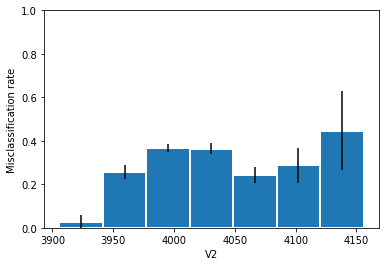

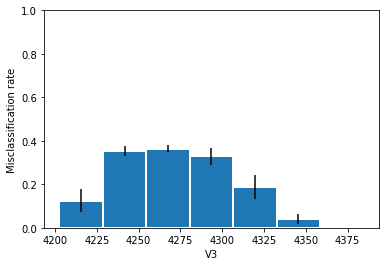

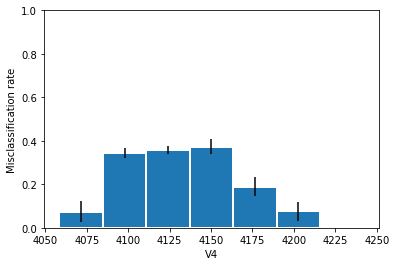

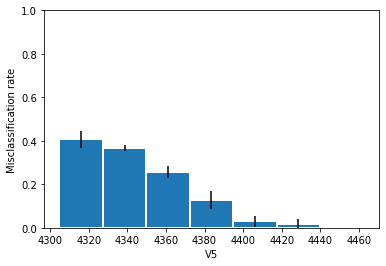

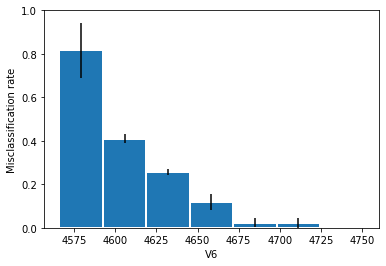

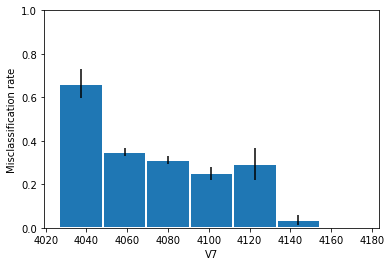

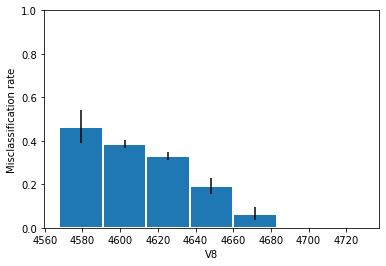

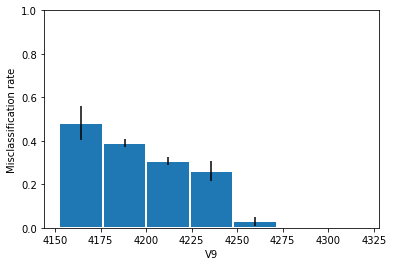

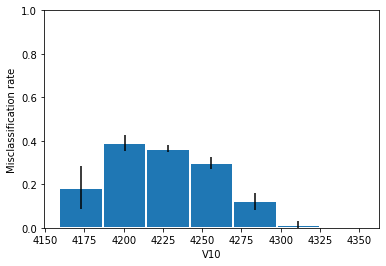

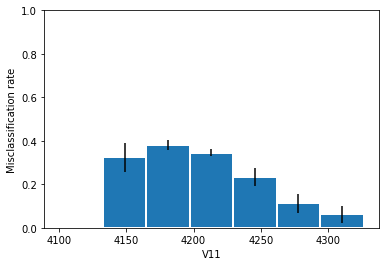

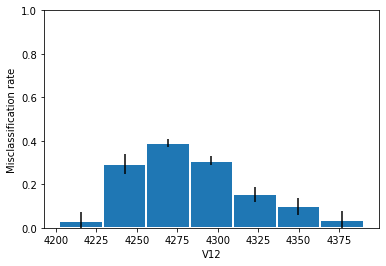

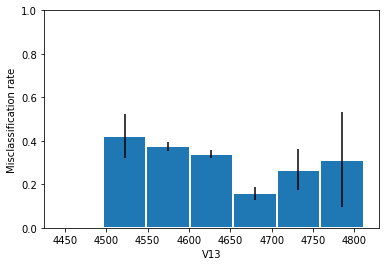

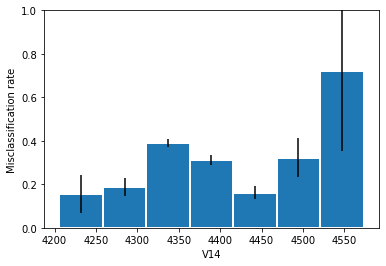

In [35]:
show_misclass_rates_features(dataset_test, y_test_predict, bins=7)

### Misclassification rate by quartiles

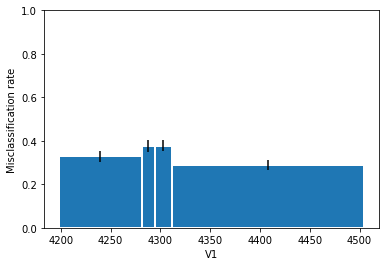

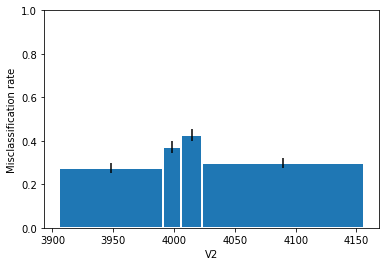

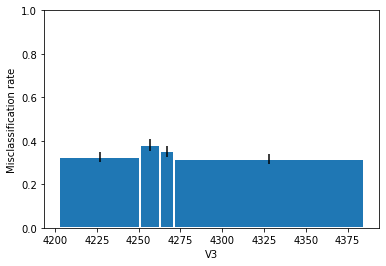

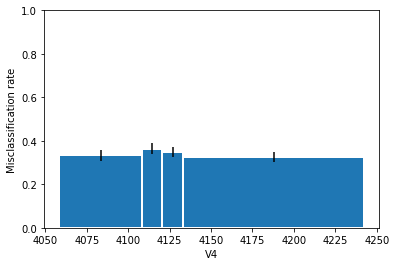

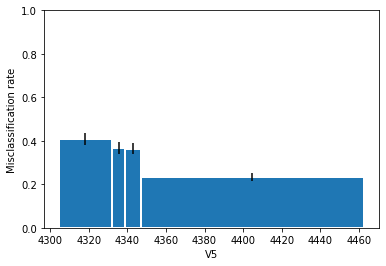

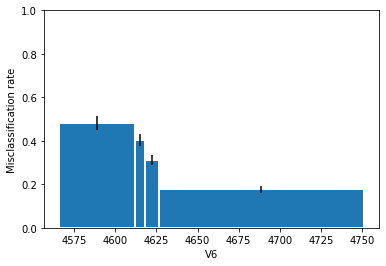

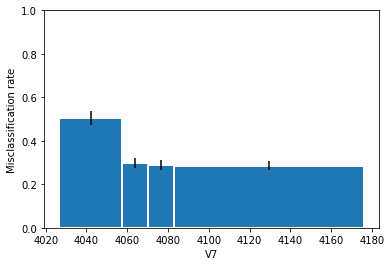

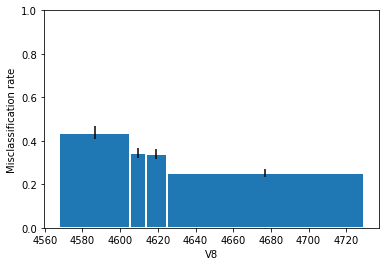

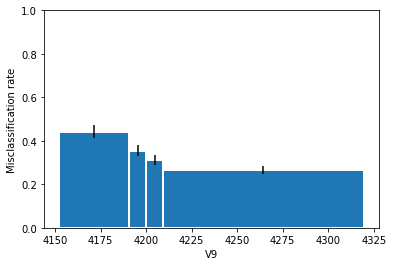

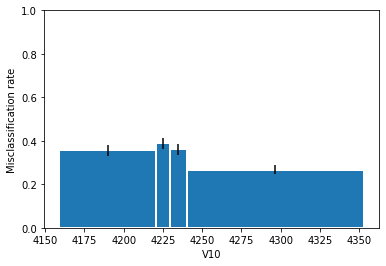

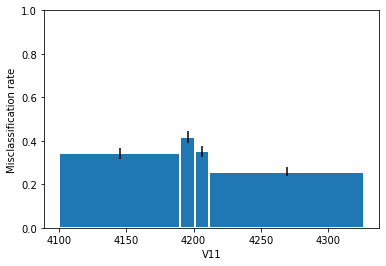

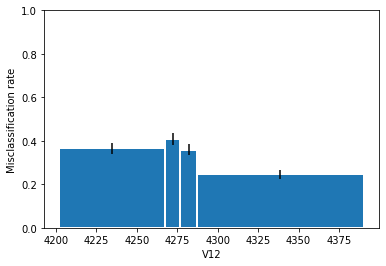

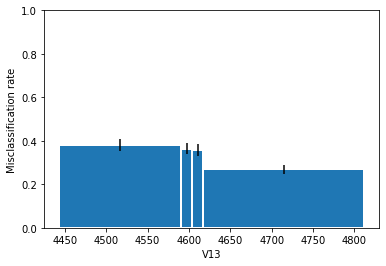

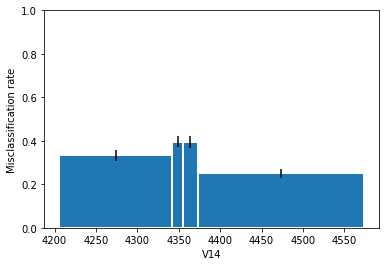

In [36]:
show_misclass_rates_features(dataset_test, y_test_predict, bins="quartiles")

### Goodness of the quartiles

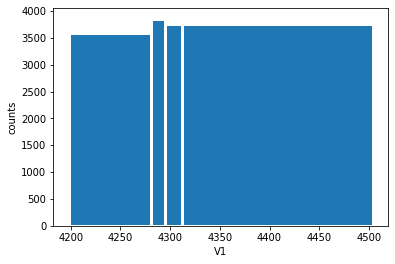

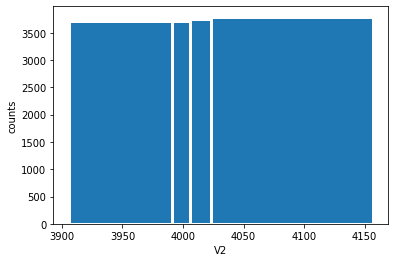

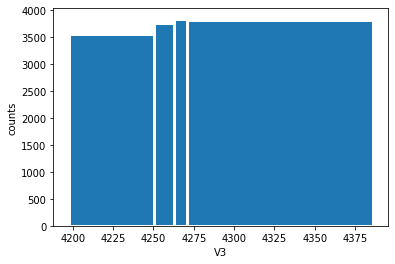

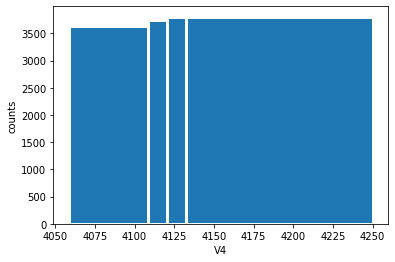

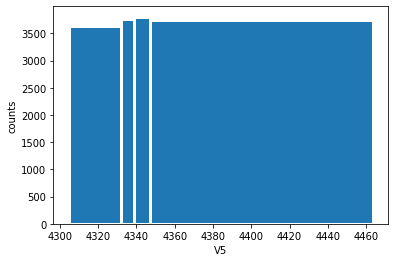

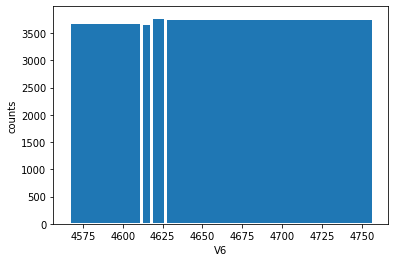

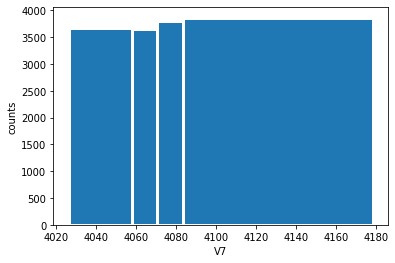

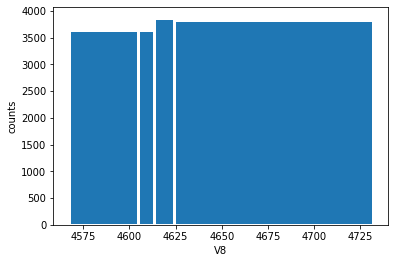

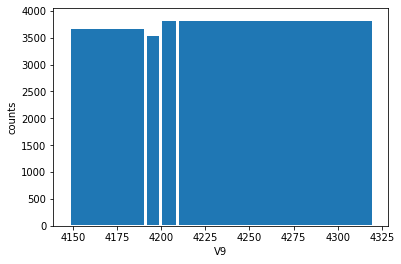

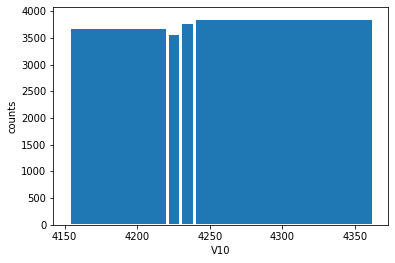

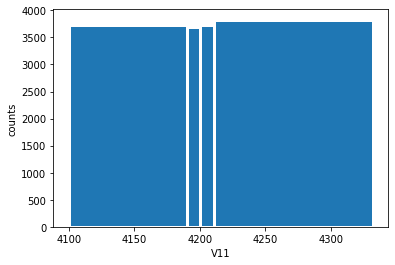

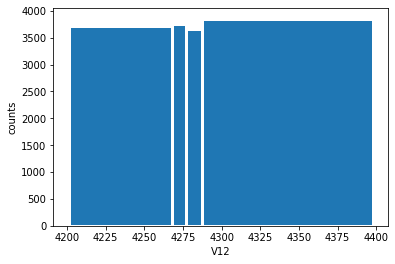

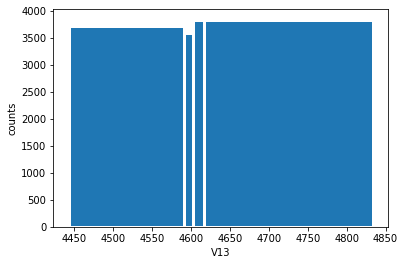

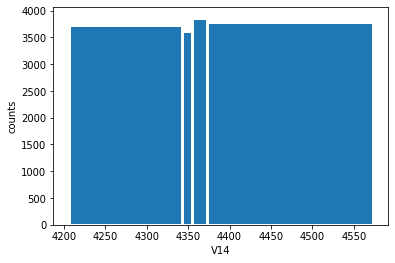

In [37]:
show_quantiles_features(dataset, quantiles=4)

--------------